In [3]:
import sys
print(sys.version)
import sys
print(sys.executable)

3.11.8 (v3.11.8:db85d51d3e, Feb  6 2024, 18:02:37) [Clang 13.0.0 (clang-1300.0.29.30)]
/Users/raju/raju/bin/python


In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
import os
import random
from collections import defaultdict
from pathlib import Path
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
import yaml
from dataclasses import dataclass, asdict
from nltk.translate.bleu_score import sentence_bleu

import torch
from torch import nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

Using device: mps
True
True


In [5]:
import tensorflow as tf
if tf.config.experimental.list_physical_devices('GPU'):
    print("Using GPU.")
else:
    print("GPU not found.")

Using GPU.


In [6]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
class Config:
    magnification: int = 20
    path: str = "/Users/raju/Raju Mac/UW/Research Paper/HistoPatch/input_image/patches_captions"
    batch_size: int = 1
    extract_batch_size: int = 16
    output_path: str = "/Users/raju/Raju Mac/UW/Research Paper/HistoPatch/Feature"
    captions_csv_path: str = "/Users/raju/Raju Mac/UW/Research Paper/HistoPatch/captions.csv"
    base_model_name = "AAE_NET"
    num_aug_repeat: int = 4
    augment: bool = False
    features_path: str = f"{output_path}/features/{base_model_name}"
    embedding_dim: int = 512
    units: int = 512
    patch_size: int = 300
    wandb_mode: str = "disabled"
    wandb_project: str = "histo_image_captions"
    epochs: int = 50
    cache_features: bool = True

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),  # Add batch normalization layer
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)  # Add dropout layer
            )

        # Encoder
        self.enc_conv1 = conv_block(3, 64)
        self.enc_conv2 = conv_block(64, 64)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc_conv3 = conv_block(64, 128)
        self.enc_conv4 = conv_block(128, 128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.enc_conv5 = conv_block(128, 256)
        self.enc_conv6 = conv_block(256, 256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.enc_conv7 = conv_block(256, 512)
        self.enc_conv8 = conv_block(512, 512)
        self.pool4 = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(enc1)
        pool1 = self.pool1(enc2)

        enc3 = self.enc_conv3(pool1)
        enc4 = self.enc_conv4(enc3)
        pool2 = self.pool2(enc4)

        enc5 = self.enc_conv5(pool2)
        enc6 = self.enc_conv6(enc5)
        pool3 = self.pool3(enc6)

        enc7 = self.enc_conv7(pool3)
        enc8 = self.enc_conv8(enc7)
        pool4 = self.pool4(enc8)

        return pool4, enc8, enc6, enc4, enc2

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),  # Add batch normalization layer
                nn.ReLU(inplace=True),
                nn.Dropout(0.25)  # Add dropout layer

            )

        def upsample(in_channels, out_channels):
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                nn.ReLU(inplace=True)
            )

        # Decoder
        self.upsample1 = upsample(512, 256, )
        self.dec_conv1 = conv_block(512+256, 256)
        
        self.upsample2 = upsample(256, 128, )
        self.dec_conv2 = conv_block(256+128, 128)

        self.upsample3 = upsample(128, 64)
        self.dec_conv3 = conv_block(128+64, 64)

        self.upsample4 = upsample(64, 32)
        self.dec_conv4 = conv_block(64+32, 32)
        
        self.final_conv = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, enc8, enc6, enc4, enc2):
        x = self.upsample1(x)
        x = F.interpolate(x, size=enc8.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, enc8), dim=1)
        x = self.dec_conv1(x)


        x = self.upsample2(x)
        x = F.interpolate(x, size=enc6.size()[2:], mode='bilinear', align_corners=False)
        x = torch.cat((x, enc6), dim=1)
        x = self.dec_conv2(x)

        x = self.upsample3(x)
        x = torch.cat((x, enc4), dim=1)
        x = self.dec_conv3(x)

        x = self.upsample4(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.dec_conv4(x)

        x = self.final_conv(x)
        return x
        
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(512*18*18, 256),
            nn.BatchNorm1d(256)  # Add batch normalization layer
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128)  # Add batch normalization layer
        )
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# x = torch.randn(1, 3, 300, 300)
        
# # Instantiate the encoder and decoder
# encoder = Encoder()
# decoder = Decoder()
# # Pass the tensor through the encoder
# pool4, enc8, enc6, enc4, enc2 = encoder(x)
# output = decoder(pool4, enc8, enc6, enc4, enc2)

# # Pass the encoded tensor and skip connections through the decoder

# print(f"Input shape: {output.shape}")

class AAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.discriminator = Discriminator()

    def forward(self, x):
        enc_out, enc8, enc6, enc4, enc2 = self.encoder(x)
        decoded = self.decoder(enc_out, enc8, enc6, enc4, enc2)
        validity = self.discriminator(enc_out)
        return decoded, validity

In [16]:
def prepare_data(config):
    path = config.path
    image_ids = set([p.stem.split("_")[0]
                     for p in Path(config.path).glob(f"*.jpg")])
    print(len(image_ids))
    if not image_ids:
        raise SystemExit(
            f"Patches not found. Make sure you have the jpg patches at {path}"
        )
    with open(config.captions_csv_path) as f:
        df = pd.read_csv(f)
        print(len(df))
    image_id_to_caption = {}
    image_id_to_label = {}
    text_data = []
    for i in range(len(df)):
        image_id = df.iloc[i]["id"]
        if image_id in image_ids:
            caption = df.iloc[i]["text"]
            caption = "<start> " + caption.replace('"', "").strip() + " <end>"
            text_data.append(caption)
            image_id_to_caption[image_id] = caption
            image_id_to_label[image_id] = df.iloc[i]["subtype"]
    return image_id_to_caption, image_id_to_label, text_data

def split_train_val_ids(
    image_id_to_label,
    split=(0.7, 0.8, 1.0),
):
    random.seed(1)
    labels = set(image_id_to_label.values())
    ids_train, ids_val, ids_test = [], [], []
    for label in labels:
        image_ids = [
            image_id
            for image_id, image_label in image_id_to_label.items()
            if image_label == label
        ]
        random.shuffle(image_ids)
        n = len(image_ids)
#         print(label, n)
        ids_train.extend(image_ids[: int(split[0] * n)])
        ids_val.extend(image_ids[int(split[0] * n): int(split[1] * n)])
        ids_test.extend(image_ids[int(split[1] * n): int(split[2] * n)])
    print("ids_train",len(ids_train),"ids_val",len(ids_val), "ids_test", len(ids_test))
    return ids_train, ids_val, ids_test

def split_train_val_features(
    ids_train,
    ids_val,
    ids_test,
    image_id_to_caption_sequence,
    feature_paths,
):
    features_path_train = []
    captions_train = []
    image_ids_train = []
    features_path_val = []
    captions_val = []
    image_ids_val = []
    features_path_test = []
    captions_test = []
    image_ids_test = []
    for path in feature_paths:
        image_id = path.stem.split("_")[0]
        path = str(path)
        if image_id in ids_train:
            features_path_train.append(path)
            captions_train.extend(image_id_to_caption_sequence[image_id])
            image_ids_train.append(image_id)
        if image_id in ids_val:
            features_path_val.append(path)
            captions_val.extend(image_id_to_caption_sequence[image_id])
            image_ids_val.append(image_id)
        if image_id in ids_test:
            features_path_test.append(path)
            captions_test.extend(image_id_to_caption_sequence[image_id])
            image_ids_test.append(image_id)

    return (
        features_path_train,
        image_ids_train,
        captions_train,
        features_path_val,
        image_ids_val,
        captions_val,
        features_path_test,
        image_ids_test,
        captions_test,
    )

# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [22]:
# # Instantiate the Encoder
# model = AAE()
# # Load the saved weights on the CPU
# saved_weights_path = "/Users/raju/Desktop/HistoPatch/model/model_weights.pth"
# model.load_state_dict(torch.load(saved_weights_path, map_location=torch.device('cpu')))

# x = np.random.rand(1, 3, 300, 300)  # Add a batch dimension

# with torch.no_grad():
#     enc_out, _, _, _ = model.encoder(torch.tensor(x, dtype=torch.float32))
# print(enc_out.shape)
# enc_out_permuted = enc_out.permute(0, 2, 3, 1)
# enc_out_numpy = enc_out_permuted.numpy()
# enc_out_tf = tf.convert_to_tensor(enc_out_numpy)
# print(enc_out_tf.shape)

In [23]:
import torch
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader

model = AAE()
# Load the saved weights on the CPU
saved_weights_path = "/Users/raju/Raju Mac/UW/Research Paper/HistoPatch/model/model_weights.pth"
model.load_state_dict(torch.load(saved_weights_path, map_location=torch.device('mps')))
model = model.to(device)

In [24]:

def extract_features_from_tiles(image_ids, train_ids, config: Config):

    def load_image(image_path):
        img = Image.open(image_path)
        preprocess = transforms.Compose([
            transforms.ToTensor()])
        img = preprocess(img)
        return img

    for image_id in image_ids:
        for i in range(config.num_aug_repeat if config.augment else 1):
            features_path = f"{config.features_path}/{image_id}.npz"
            if Path(features_path).exists():
                continue
            try:
                paths = list(Path(config.path).glob(f"{image_id}*"))
                image_ds = [load_image(str(path)) for path in paths]
                image_loader = DataLoader(image_ds, batch_size=config.extract_batch_size)
                image_features = []
                with torch.no_grad():
                    for images in image_loader:
                        images = images.to(device)
                        enc_out, _, _, _,_ = model.encoder(images)
                        enc_out_permuted = enc_out.permute(0, 2, 3, 1)
                        enc_out_numpy = enc_out_permuted.cpu().numpy()  # Add .cpu() before .numpy()
                        enc_out_tf = tf.convert_to_tensor(enc_out_numpy)
                        image_features.append(enc_out_tf)
                image_features = np.concatenate(image_features, axis=0)
                print(image_features.shape)
                np.savez_compressed(
                    features_path,
                    features=image_features,
                    image_id=image_id,
                    paths=[path.stem for path in paths],
                )
            except Exception as e:
                print(e)

In [22]:
config = Config()  # You need to define Config() and its parameters

Path(config.features_path).mkdir(parents=True, exist_ok=True)

paths = list(Path(config.path).glob("*.jpg"))
image_ids = {path.stem.split("_")[0] for path in paths}

image_id_to_caption, image_id_to_label, text_data = prepare_data(config)
ids_train, ids_val, ids_test = split_train_val_ids(
    image_id_to_label=image_id_to_label
)

with wandb.init(
    project=config.wandb_project,
    mode=config.wandb_mode,
    reinit=True,
    config=config,
) as run:
    if config.cache_features:
        extract_features_from_tiles(
            image_ids=image_ids, train_ids=ids_train, config=config
        )
    tf.keras.backend.clear_session()

991
991
ids_train 688 ids_val 100 ids_test 203


In [23]:
config = Config()  # You need to define Config() and its parameters
# use the ones that have extracted features
feature_paths = list(Path(config.features_path).glob("*.npz"))
train_ids = list({path.stem.split("_")[0] for path in feature_paths})

image_id_to_caption = {
    k: v for k, v in image_id_to_caption.items() if k in train_ids
}
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+-/.,:;=?@[\]^_`{|}~')

tokenizer.fit_on_texts(image_id_to_caption.values())

tokenizer.word_index["<pad>"] = 0
tokenizer.index_word[0] = "<pad>"
train_seqs = tokenizer.texts_to_sequences(image_id_to_caption.values())


cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
    train_seqs, padding="post"
)

image_id_to_caption_sequence = defaultdict(list)
for img, cap in zip(image_id_to_caption.keys(), cap_vector):
    image_id_to_caption_sequence[img].append(cap)

max_length = calc_max_length(train_seqs)
print(max_length)
    
(
    features_path_train,
    image_ids_train,
    captions_train,
    features_path_val,
    image_ids_val,
    captions_val,
    features_path_test,
    image_ids_test,
    captions_test,
) = split_train_val_features(
    ids_train,
    ids_val,
    ids_test,
    image_id_to_caption_sequence=image_id_to_caption_sequence,
    feature_paths=feature_paths,
)

print( 
    len(features_path_train),
    len(captions_train),
    len(image_ids_train),
    len(features_path_val),
    len(captions_val),
    len(features_path_test),
    len(captions_test),
)

48
688 688 688 100 100 203 203


In [18]:
import numpy as np
import tensorflow as tf

max_iamgesize = 1500

def map_func(features, captions, keys):
    img_tensor = np.load(features.decode("utf-8"))["features"]
    if img_tensor.ndim > 2:
        # Take the mean over the middle two dimensions
        # img_tensor = np.reshape(img_tensor, (img_tensor.shape[0], -1))
        img_tensor = np.mean(img_tensor, axis=(1,2))

    np.random.shuffle(img_tensor)
    return img_tensor, captions, keys

def pad_to_fixed_size(data, fixed_size):
    # If the number of images is less than the fixed size, pad the data
    if tf.shape(data)[0] < fixed_size:
        paddings = [[0, fixed_size - tf.shape(data)[0]], [0, 0]]
        data = tf.pad(data, paddings)
    # If the number of images is more than the fixed size, truncate the data
    else:
        data = data[:fixed_size]
    return data

def prepare_dataset(features, captions, keys, config, shuffle=True):
    data = (features, captions, keys)

    dataset = tf.data.Dataset.from_tensor_slices(data)

    if shuffle:
        dataset = dataset.shuffle(1000)
    # Use map to load the numpy files in parallel
    dataset = dataset.map(
        lambda item1, item2, item3: tf.numpy_function(
            map_func, [item1, item2, item3], [tf.float32, tf.int32, tf.string]
        ),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    
    # Pad the data to a fixed size
    dataset = dataset.map(
        lambda img_tensor, caption, key: (pad_to_fixed_size(img_tensor, max_iamgesize), caption, key),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle and batch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [19]:
train_ds = prepare_dataset(features_path_train, 
    captions_train,
    image_ids_train, config)
val_ds = prepare_dataset(
    features_path_val,
    captions_val,
    keys=image_ids_val,
    shuffle=False,
    config=config)
test_ds = prepare_dataset(
    features_path_test,
    captions_test,
    keys=image_ids_test,
    shuffle=False,
    config=config)
for features, captions, keys in train_ds.take(1):
    print("Features: ", features.shape)
    print("Features: ", features)
    print("Captions: ", captions)
    print("Keys: ", keys)

Features:  (1500, 512)
Features:  tf.Tensor(
[[1.4780854 0.        1.7170913 ... 0.        0.        1.2671627]
 [1.4867193 0.        1.7225323 ... 0.        0.        1.2570162]
 [1.4806387 0.        1.6860192 ... 0.        0.        1.2666072]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]], shape=(1500, 512), dtype=float32)
Captions:  tf.Tensor(
[ 5  7  8 26 23 51 44 32 22 11 25 10 42 16 50 12 15 19  4 14  9 33  3  2
 49 35 39  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(48,), dtype=int32)
Keys:  tf.Tensor(b'b35c55ffaee54978b40d40cb34228b5e', shape=(), dtype=string)


2024-04-23 22:23:48.249831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Add
from tensorflow.keras.layers import Dropout

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


class TransformerModel:
    def __init__(self, num_images, num_image_features, latent_dim, num_words, num_word_features):
        self.num_images = num_images
        self.num_image_features = num_image_features
        self.latent_dim = latent_dim
        self.num_words = num_words
        self.num_word_features = num_word_features

    def create_encoder(self, encoder_inputs):
        # Add positional encoding
        positional_encoding = PositionalEncoding(self.num_images, self.num_image_features)
        encoder_inputs = positional_encoding(encoder_inputs)

        # Multi-head self-attention layer for the encoder
        attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(encoder_inputs, encoder_inputs)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([encoder_inputs, attention_output]))  # Residual connection and layer normalization

        # Dropout layer
        attention_output = Dropout(0.2)(attention_output)

        # Transform the encoder's output to have the same last dimension as the decoder's input
        transformed_output = Dense(self.num_word_features)(attention_output)
        return transformed_output

    def create_decoder(self, decoder_inputs, encoder_outputs):
        # Add positional encoding
        positional_encoding = PositionalEncoding(self.num_words, self.num_word_features)
        decoder_inputs = positional_encoding(decoder_inputs)

        # Multi-head self-attention layer for the decoder
        attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(decoder_inputs, decoder_inputs)
        attention_output = LayerNormalization(epsilon=1e-6)(Add()([decoder_inputs, attention_output]))  # Residual connection and layer normalization

        # Dropout layer
        attention_output = Dropout(0.2)(attention_output)

        # Multi-head encoder-decoder attention mechanism
        attention_output_2 = MultiHeadAttention(num_heads=8, key_dim=64)(attention_output, encoder_outputs)
        attention_output_2 = LayerNormalization(epsilon=1e-6)(Add()([attention_output, attention_output_2]))  # Residual connection and layer normalization

        # Dropout layer
        attention_output_2 = Dropout(0.2)(attention_output_2)

        # Feed-forward layer
        decoder_outputs = Dense(self.num_word_features, activation='relu')(attention_output_2)
        decoder_outputs = LayerNormalization(epsilon=1e-6)(Add()([attention_output_2, decoder_outputs]))  # Residual connection and layer normalization
        return decoder_outputs

    def build_model(self):
        # Define inputs
        encoder_inputs = Input(shape=(None, self.num_image_features), name="encoder_inputs")
        decoder_inputs = Input(shape=(None, self.num_word_features), name="decoder_inputs")

        # Create encoder and decoder
        encoder_outputs = self.create_encoder(encoder_inputs)
        decoder_outputs = self.create_decoder(decoder_inputs, encoder_outputs)

        # Output layer
        decoder_outputs = Dense(self.num_word_features, activation='softmax', name='decoder_relu')(decoder_outputs)

        # Create the model
        model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
        return model

In [21]:
encoder_input_data = []
decoder_input_data = []
decoder_target_data = []

num_decoder_tokens = len(tokenizer.word_index)
for img_tensor, caption, key in train_ds:
    encoder_input_data.append(img_tensor)
    y = to_categorical(caption, num_decoder_tokens)
    decoder_input_data.append(y[:-1])
    decoder_target_data.append(y[1:])

encoder_input_train = np.array(encoder_input_data)
decoder_input_train = np.array(decoder_input_data)
decoder_target_train = np.array(decoder_target_data)

encoder_input_data = []
decoder_input_data = []
decoder_target_data = []

for img_tensor, caption, key in val_ds:
    encoder_input_data.append(img_tensor)
    y = to_categorical(caption, num_decoder_tokens)
    decoder_input_data.append(y[:-1])
    decoder_target_data.append(y[1:])

encoder_input_val = np.array(encoder_input_data)
decoder_input_val = np.array(decoder_input_data)
decoder_target_val = np.array(decoder_target_data)

2024-04-23 22:24:41.946577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-04-23 22:24:52.414544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [22]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras import backend as K

# Clear the session
K.clear_session()

num_decoder_tokens = len(tokenizer.word_index)
train_len = encoder_input_train.shape[0]
patch = encoder_input_train.shape[1]
features = encoder_input_train.shape[2]
d_model = 512
caption_len = max_length - 1
# Instantiate the model
model = TransformerModel(num_images=patch, num_image_features=features, latent_dim=d_model, num_words=caption_len, num_word_features=num_decoder_tokens).build_model()


# Define initial learning rate
initial_learning_rate = 0.001
epochs = 50

# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=train_len,
    decay_rate= 0.96,
    staircase=True
)

# Compile the model with Adam optimizer and learning rate schedule
model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

# Train the model
# Train the model and save the history
history4 = model.fit([encoder_input_train, decoder_input_train], decoder_target_train, 
                    epochs=50, 
                    batch_size=32,
                    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val))

# Save the training loss and validation loss to a text file
with open('training_history4.txt', 'w') as f:
    f.write(str(history4.history))

Epoch 1/50


2024-04-23 22:24:54.482612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 3.6958 - val_loss: 2.1094
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 2.1581 - val_loss: 1.9519
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 1.9518 - val_loss: 1.7424
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 1.7987 - val_loss: 1.5268
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 1.6222 - val_loss: 1.3999
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 1.4146 - val_loss: 1.0845
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 1.1400 - val_loss: 0.9326
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.9827 - val_loss: 0.8118
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.8820 - val_loss: 0.7338
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.8203 - val_loss: 0.6579
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.7123 - val_loss: 0.6225
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 0.6468 - val_loss: 0.6069


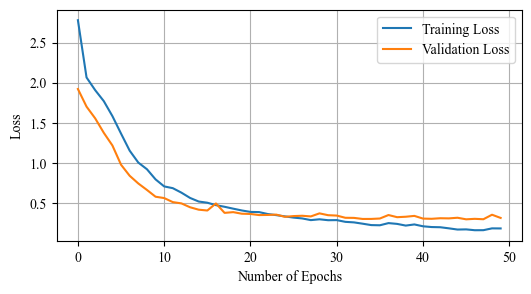

In [21]:
import matplotlib.pyplot as plt

# Set the global font to be Times New Roman, size 10
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

# Plot the training and validation loss
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('UNet+AAE_TR_loss.pdf', bbox_inches='tight', dpi=320)

In [22]:
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical

# Prepare the test data
encoder_input_data = []
decoder_input_data = []
decoder_target_data = []

for img_tensor, caption, key in test_ds:
    encoder_input_data.append(img_tensor)
    y = to_categorical(caption, num_decoder_tokens)
    decoder_input_data.append(y[:-1])
    decoder_target_data.append(y[1:])

encoder_input_test = np.array(encoder_input_data)
decoder_input_test = np.array(decoder_input_data)
decoder_target_test = np.array(decoder_target_data)

print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(203, 1500, 512)
(203, 47, 344)
(203, 47, 344)


2024-04-21 19:03:57.471248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [23]:
# Initialize variables
actual, predicted = list(), list()

num_decoder_tokens = len(tokenizer.word_index)
patch = encoder_input_test.shape[1]
features = encoder_input_test.shape[2]
d_model = 512
caption_len = max_length - 1

# Iterate over the test dataset
for i in range(len(encoder_input_test)):
    # Generate description
    yhat = model.predict([encoder_input_test[i].reshape(1, patch, features), decoder_input_test[i].reshape(1, caption_len, num_decoder_tokens)], verbose=0)
    yhat = np.argmax(yhat, axis=-1)
    print(yhat)
    # Convert integer sequences to words
    ytrue = decoder_target_test[i].reshape(1, caption_len, num_decoder_tokens)
    ytrue = np.argmax(ytrue, axis=-1)
    
    actual_desc = [tokenizer.index_word[i] for i in ytrue[0] if i != 0]
    predicted_desc = [tokenizer.index_word[i] for i in yhat[0] if i != 0]
    
    print("actual", actual_desc)
    print("predict", predicted_desc)
    # Store actual and predicted descriptions
    actual.append([actual_desc])
    predicted.append(predicted_desc)

[[ 7 40 30 27 53 52 27 60 58 48 16 30 61 36 57 62 38  2  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
actual ['tumor', 'cells', 'are', 'large', 'highly', 'columnar', 'large', 'club', 'shaped', 'nuclei', 'and', 'are', 'associated', 'with', 'chromatin', 'aggregation', 'papillary', 'adenocarcinoma', '<end>']
predict ['tumor', 'cells', 'are', 'large', 'highly', 'columnar', 'large', 'club', 'shaped', 'nuclei', 'and', 'are', 'associated', 'with', 'chromatin', 'aggregation', 'papillary', 'adenocarcinoma', '<end>']
[[ 7 40 30 27 53 52 27 60 58 48 16 30 61 36 57 62 38  2  6  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
actual ['tumor', 'cells', 'are', 'large', 'highly', 'columnar', 'large', 'club', 'shaped', 'nuclei', 'and', 'are', 'associated', 'with', 'chromatin', 'aggregation', 'papillary', 'adenocarcinoma', '<end>']
predict ['tumor', 'cells', 'are', 'large', 'highly', 'columnar', 'large', 'club', 'shaped'

In [25]:
from nltk.translate import meteor_score
from rouge_score import rouge_scorer
from pycocoevalcap.meteor.meteor import Meteor
from nltk.translate.bleu_score import corpus_bleu

# Calculate BLEU scores for n-grams from 1 to 4
bleu_1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
# Print the BLEU scores
print(f"BLEU-1 Score: {bleu_1}")
print(f"BLEU-2 Score: {bleu_2}")
print(f"BLEU-3 Score: {bleu_3}")
print(f"BLEU-4 Score: {bleu_4}")

# Initialize the scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

total_rouge_l = 0
tolal_meteor = 0
# Calculate the METEOR score
for i in range(len(actual)):
    meteor = meteor_score.single_meteor_score(actual[i][0], predicted[i])
    tolal_meteor += meteor
    a = ' '.join(map(str, actual[i][0]))
    p = ' '.join(map(str, predicted[i]))
    rough = scorer.score(a, p)
    rouge_l = rough['rougeL'].fmeasure
    total_rouge_l += rouge_l
    
mean_rouge_l = (total_rouge_l / len(actual))
mean_meteor = (tolal_meteor / len(actual))
print(mean_rouge_l, mean_meteor)

BLEU-1 Score: 0.8933435881784495
BLEU-2 Score: 0.8614451022921302
BLEU-3 Score: 0.84203503521653
BLEU-4 Score: 0.8247261563821134
0.8781055110309111 0.8710413031910714


In [26]:
import json

references_data = {
    "images": [],
    "annotations": []
}

# Prepare the data for the captions.json file
captions_data = []

# Populate the data
for i in range(len(actual)):
    # Add the image information to the references data
    references_data["images"].append({"id": i})

    # Add the annotation (caption) information to the references data
    references_data["annotations"].append({
        "image_id": i,
        "id": i,
        "caption": ' '.join(map(str, actual[i][0]))  # added closing parenthesis here
    })

    # Add the caption information to the captions data
    captions_data.append({
        "image_id": i,
        "caption": ' '.join(map(str, predicted[i]))
    })

# Save the data to the json files
with open("references.json", "w") as fgts:
    json.dump(references_data, fgts)

with open("captions.json", "w") as fres:
    json.dump(captions_data, fres)


In [27]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

annotation_file = 'references.json'
results_file = 'captions.json'

# create coco object and coco_result object
coco = COCO(annotation_file)
coco_result = coco.loadRes(results_file)

# create coco_eval object by taking coco and coco_result
coco_eval = COCOEvalCap(coco, coco_result)

# remove SPICE from the list of metrics
# evaluate results
coco_eval.evaluate()

# print output evaluation scores
for metric, score in coco_eval.eval.items():
    print(f'{metric}: {score:.3f}')


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
tokenization...


PTBTokenizer tokenized 5265 tokens at 102823.58 tokens per second.
PTBTokenizer tokenized 5261 tokens at 136831.20 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 5059, 'reflen': 5063, 'guess': [5059, 4856, 4653, 4450], 'correct': [4523, 4037, 3727, 3469]}
ratio: 0.9992099545721904
Bleu_1: 0.893
Bleu_2: 0.861
Bleu_3: 0.841
Bleu_4: 0.825
computing METEOR score...
METEOR: 0.577
computing Rouge score...
ROUGE_L: 0.875
computing CIDEr score...
CIDEr: 7.500
computing SPICE score...


Exception in thread "main" java.lang.ExceptionInInitializerError
	at edu.anu.spice.SpiceParser.<init>(SpiceParser.java:178)
	at edu.anu.spice.SpiceScorer.scoreBatch(SpiceScorer.java:70)
	at edu.anu.spice.SpiceScorer.main(SpiceScorer.java:60)
Caused by: java.lang.reflect.InaccessibleObjectException: Unable to make field private final byte[] java.lang.String.value accessible: module java.base does not "opens java.lang" to unnamed module @673ba40c
	at java.base/java.lang.reflect.AccessibleObject.throwInaccessibleObjectException(AccessibleObject.java:391)
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:367)
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:315)
	at java.base/java.lang.reflect.Field.checkCanSetAccessible(Field.java:183)
	at java.base/java.lang.reflect.Field.setAccessible(Field.java:177)
	at org.nustaq.serialization.FSTClazzInfo.createFieldInfo(FSTClazzInfo.java:499)
	at org.nustaq.serial

CalledProcessError: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', '/Users/raju/raju/lib/python3.11/site-packages/pycocoevalcap/spice/tmp/tmpmowwxgom', '-cache', '/Users/raju/raju/lib/python3.11/site-packages/pycocoevalcap/spice/cache', '-out', '/Users/raju/raju/lib/python3.11/site-packages/pycocoevalcap/spice/tmp/tmpgxmp0xe5', '-subset', '-silent']' returned non-zero exit status 1.